# 3.1 推論ベースの手法とニューラルネットワーク

In [34]:
import sys
sys.path.append('..')
import numpy as np
from common.trainer import Trainer
from common.optimizer import Adam
from common.layers import MatMul, SoftmaxWithLoss
from common.util import preprocess

単語IDが0の単語を全結合層で変換する例

In [2]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])
print(c.shape)  # ミニバッチ処理を考えて2次元にしている
W = np.random.randn(7, 3)
h = np.dot(c, W)
print(h)

(1, 7)
[[-1.09728408 -1.13072285 -0.67038047]]


MatMulレイヤを使う

In [3]:
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-1.09728408 -1.13072285 -0.67038047]]


# 3.2 シンプルなword2vec (CBOWモデル)

## CBOWモデルの推論処理
**入力層 - 中間層 - 出力層** という単純なモデルを考える
- 入力層と出力層のニューロンの数は単語ベクトルの要素数
- 入力層の数はコンテキストとして与える単語数
- 全ての入力層から中間層への変換は重み$\mathrm{W_{in}}$の全結合層によって，中間層から出力層への変換は重み$\mathrm{W_{out}}$の全結合層によって行われる
- 中間層は各入力層の全結合による変換後の値を平均したもの
- 出力層の値は各単語のスコア．Softmax関数を適用すると各単語の確率になる．
- 学習後の重み$\mathrm{W_{in}}, \mathrm{W_{out}}$が単語の分散表現になる．中間層のニューロンの数を入力層よりも少なくすることで，密なベクトルが得られる．

In [4]:
# サンプルデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重み初期化
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# レイヤ生成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# forward
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

# スコア出力
print(s)

[[ 1.18877249 -0.45986095 -0.82221905  0.42213327 -2.04103295  0.30722039
   0.10442348]]


## CBOWモデルの学習
ネットワークから出力されるスコアにSoftmax関数を適用することで確率を得ることができる．上の例では，単語IDが0と2の単語と共起する単語を予測するようなタスクを考えている．正解が単語IDが1の単語であれば，s[1]が最も高くなるように重みを調整することになる．  
追加する層は
- Softmaxレイヤ
- Cross Entropy Errorレイヤ

の2つ．すでに実装しているSoftmax with Lossレイヤで実装できる．

<br/>

最終的に利用する単語の分散表現の選択肢は次の3つ
- 入力側の重み: 行ベクトルが各単語の分散表現に対応．こちらだけを使うのが最もポピュラーな方法．
- 出力側の重み: 列ベクトルが各単語の分散表現に対応．
- 入出力の重み: 両方を足し合わせるなどの方法
***

# 3.3 学習データの準備
## コンテキストとターゲット
**コーパス &rarr; (コンテキスト & ターゲット)** という処理を行う  
まずはコーパスを作る

In [5]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(f'corpus: {corpus}')
print(f'id_to_word: {id_to_word}')

corpus: [0 1 2 3 4 1 5 6]
id_to_word: {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


コンテキストとターゲットを作る関数を実装

In [6]:
def create_contexts_target(corpus, window_size=1):
    '''コンテキストとターゲットの作成
    :param corpus: コーパス（単語IDのリスト）
    :param window_size: ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return: tuple (contexts, target)
    '''
    target = corpus[window_size:-window_size]  # 端の単語を除く
    contexts = []

    # コーパスの両端からwindow_size分を除いてループ
    # ターゲットのidxになる
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        # 今のidxから前後window_size分を見てコンテキストとして追加する
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [7]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(f'contexts:\n{contexts}')
print(f'target: {target}')

contexts:
[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
target: [1 2 3 4 1 5]


## one-hot表現への変換
NNに入力するためone-hotベクトルに変換する

In [8]:
def convert_one_hot(corpus, vocab_size):
    '''one-hot表現への変換
    :param corpus: 単語IDのリスト（1次元もしくは2次元のNumPy配列）
    :param vocab_size: 語彙数
    :return: one-hot表現（2次元もしくは3次元のNumPy配列）
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [9]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [30]:
# コンテキストの形状は (batch_size, window_size, vocab_size) になる
# 今はコーパスが小さいので batch_size = data_size になっている
print(f'contexts.shape: {contexts.shape}')
print(f'contexts:\n{contexts}')
print()
print(f'target.shape: {target.shape}')
print(f'target:\n{target}')

contexts.shape: (6, 2, 7)
contexts:
[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]

target.shape: (6, 7)
target:
[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


# CBOWモデルの実装

In [32]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        # vocab_size: 語彙数
        # hidden_size: 中間層のニューロン数
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # レイヤの生成
        # in_layer はコンテキストの window_size 分必要
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])  # 0番目のwindowの単語のone-hotベクトルが入る
        h1 = self.in_layer1.forward(contexts[:, 1])  # 1番目のwindowの単語のone-hotベクトルが入る
        h = (h0 + h1) * 0.5  # 2つの入力層の値を平均する
        score = self.out_layer.forward(h)  # 出力層への変換
        loss = self.loss_layer.forward(score, target)  # 損失を計算
        return loss

    def backward(self, dout=1):
        # 各レイヤのbackword()メソッドを呼び出し，レイヤのインスタンス変数gradを更新しつつ，下流の勾配計算に必要な偏微分を返す
        # 各レイヤのインスタンス変数gradが更新されると，self.gradsも更新される (参照渡し)
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

## 学習コードの実装

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 266 |  iter 1 / 2 | time 0[s] | loss 1.02
| epoch 267 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 268 |  iter 1 / 2 | time 0[s] | loss 0.87
| epoch 269 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 270 |  iter 1 / 2 | time 0[s] | loss 1.02
| epoch 271 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 272 |  iter 1 / 2 | time 0[s] | loss 1.08
| epoch 273 |  iter 1 / 2 | time 0[s] | loss 0.91
| epoch 274 |  iter 1 / 2 | time 0[s] | loss 1.10
| epoch 275 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 276 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 277 |  iter 1 / 2 | time 0[s] | loss 1.02
| epoch 278 |  iter 1 / 2 | time 0[s] | loss 0.96
| epoch 279 |  iter 1 / 2 | time 0[s] | loss 0.94
| epoch 280 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 281 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 282 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 283 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 284 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 285 |  iter 1 / 2 | time 0[s] | loss 1.05


| epoch 558 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 559 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 560 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 561 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 562 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 563 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 564 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 565 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 566 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 567 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 568 |  iter 1 / 2 | time 0[s] | loss 0.78
| epoch 569 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 570 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 571 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 572 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 573 |  iter 1 / 2 | time 0[s] | loss 0.61
| epoch 574 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 575 |  iter 1 / 2 | time 0[s] | loss 0.71
| epoch 576 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 577 |  iter 1 / 2 | time 0[s] | loss 0.58


| epoch 866 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 867 |  iter 1 / 2 | time 0[s] | loss 0.45
| epoch 868 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 869 |  iter 1 / 2 | time 0[s] | loss 0.43
| epoch 870 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 871 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 872 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 873 |  iter 1 / 2 | time 0[s] | loss 0.39
| epoch 874 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 875 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 876 |  iter 1 / 2 | time 0[s] | loss 0.43
| epoch 877 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 878 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 879 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 880 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 881 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 882 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 883 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 884 |  iter 1 / 2 | time 0[s] | loss 0.45
| epoch 885 |  iter 1 / 2 | time 0[s] | loss 0.51


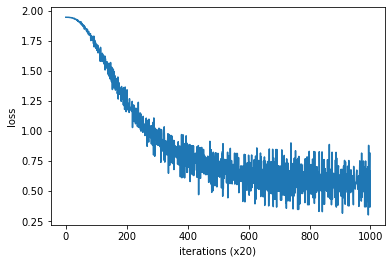

In [44]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [45]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.252908   1.0757743 -1.1131824  1.0496968 -1.1809578]
say [ 0.09271294 -1.1754436   1.1857879  -1.2008971   0.20425442]
goodbye [-0.7061587   0.702617   -0.71051437  0.68955517 -0.8012445 ]
and [-1.8154212  -1.0167191   0.98330915 -0.9682948   1.5507742 ]
i [-0.74132246  0.7020414  -0.68220496  0.70562315 -0.78782195]
hello [-1.26282    1.0552586 -1.1080751  1.0657561 -1.1748579]
. [ 1.3704281 -1.0755907  1.0592581 -1.0482092 -1.5090244]
